In [ ]:
!pip install haversine

In [ ]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, asin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("uber.csv")
print("Dataset Loaded!")
df.describe()

Dataset Loaded!


,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [ ]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [ ]:
df.shape

(200000, 9)

In [ ]:
df.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [ ]:
df=df.drop(columns='Unnamed: 0')

In [ ]:
df.dtypes

,0
key,object
fare_amount,float64
pickup_datetime,object
pickup_longitude,float64
pickup_latitude,float64
dropoff_longitude,float64
dropoff_latitude,float64
passenger_count,int64


In [ ]:
df.isnull().sum()

,0
key,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,1
dropoff_latitude,1
passenger_count,0


In [ ]:
df.columns = df.columns.str.lower()

df = df.dropna()
# df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 200)]
# df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

df = df.dropna(subset=['pickup_datetime'])


In [ ]:
df = df[
    (df['pickup_latitude'].between(40, 42)) &
    (df['pickup_longitude'].between(-75, -72)) &
    (df['dropoff_latitude'].between(40, 42)) &
    (df['dropoff_longitude'].between(-75, -72))
]


In [ ]:
from haversine import haversine as hs
df = df.copy()

def calc_haversine(row):
    start = (row['pickup_latitude'], row['pickup_longitude'])
    end = (row['dropoff_latitude'], row['dropoff_longitude'])
    return hs(start, end)

df['distance_km'] = df.apply(calc_haversine, axis=1)



# df = df[df['distance_km'] > 0]  # Remove zero distance records

In [ ]:
print(df.columns)

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance_km'],
      dtype='object')


In [ ]:
# Extract time features
df = df.copy()

df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['weekday'] = df['pickup_datetime'].dt.weekday

# STEP 4: Outlier Detection (IQR)
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
df['fare_amount'] = df['fare_amount'].clip(lower=Q1 - 1.5*IQR, upper=Q3 + 1.5*IQR)



Correlation Matrix:
                  fare_amount  distance_km  passenger_count      hour  \
fare_amount         1.000000     0.704512         0.013466 -0.012125   
distance_km         0.704512     1.000000        -0.001582 -0.031644   
passenger_count     0.013466    -0.001582         1.000000  0.013667   
hour               -0.012125    -0.031644         0.013667  1.000000   
day                 0.006664     0.005783         0.003720  0.005198   
month               0.027124     0.004585         0.009869 -0.002965   
weekday             0.020469     0.033760         0.034515 -0.088679   

                      day     month   weekday  
fare_amount      0.006664  0.027124  0.020469  
distance_km      0.005783  0.004585  0.033760  
passenger_count  0.003720  0.009869  0.034515  
hour             0.005198 -0.002965 -0.088679  
day              1.000000 -0.016009  0.005079  
month           -0.016009  1.000000 -0.009651  
weekday          0.005079 -0.009651  1.000000  


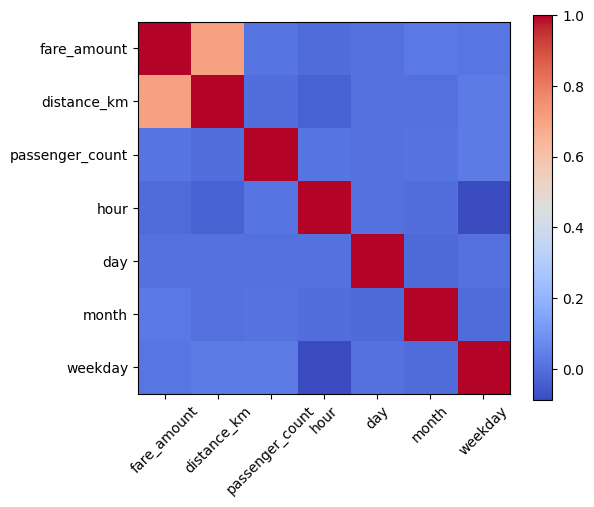

In [ ]:
corr = df[['fare_amount','distance_km','passenger_count','hour','day','month','weekday']].corr()
print("\nCorrelation Matrix:\n", corr)

plt.figure(figsize=(6,5))
plt.imshow(corr, cmap="coolwarm")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

In [ ]:
# STEP 6: Train-Test Split
X = df[['distance_km','passenger_count','hour','day','month','weekday']]
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
# STEP 7: Linear Regression Model
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

In [ ]:
# STEP 8: Random Forest Model
rf = RandomForestRegressor(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)



===== MODEL PERFORMANCE =====
Linear Regression R2   : 0.44349159689697615
Linear Regression RMSE : 3.0008739388182133
Linear Regression MAE  : 1.889770591367664

Random Forest R2       : 0.6929942803818816
Random Forest RMSE     : 2.2288719667244097
Random Forest MAE      : 1.6223050530858683


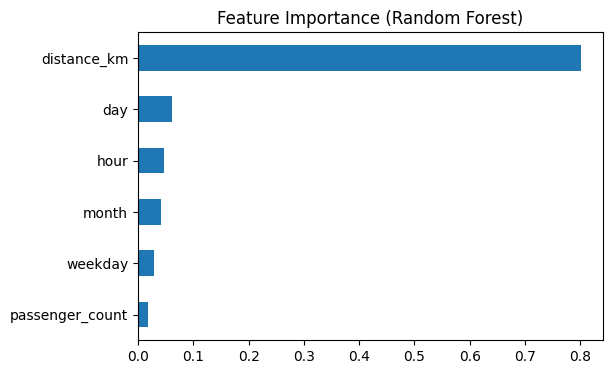

In [ ]:
# STEP 9: Evaluate Models
def rmse(a,b): return np.sqrt(mean_squared_error(a,b))

print("\n===== MODEL PERFORMANCE =====")
print("Linear Regression R2   :", r2_score(y_test,y_pred_lr))
print("Linear Regression RMSE :", rmse(y_test,y_pred_lr))
print("Linear Regression MAE  :", mean_absolute_error(y_test,y_pred_lr))

print("\nRandom Forest R2       :", r2_score(y_test,y_pred_rf))
print("Random Forest RMSE     :", rmse(y_test,y_pred_rf))
print("Random Forest MAE      :", mean_absolute_error(y_test,y_pred_rf))

# STEP 10: Feature Importance (Random Forest)
importance = pd.Series(rf.feature_importances_, index=X.columns)
importance.sort_values().plot(kind='barh', figsize=(6,4))
plt.title("Feature Importance (Random Forest)")
plt.show()